In [1]:
from scipy import *
import numpy as np
import WLanalysis
from matplotlib import pyplot

In [2]:
from matplotlib.patches import Ellipse
def plotEllipse(pos,P,edge,ls,ilabel,ax):
    '''plot the contour for covariance p
    where position is the center position
    p is the covariance [2,2] matirx'''
    U, s, Vh = svd(P) 
    orient = math.atan2(U[1,0],U[0,0])*180/pi
    ellipsePlot = Ellipse(xy=pos, width=2.0*math.sqrt(s[0]), 
                          height=2.0*math.sqrt(s[1]), angle=orient,edgecolor=edge, fill = 0, label=ilabel,ls=ls,linewidth=1.5)
    ax.add_patch(ellipsePlot)
    return ellipsePlot

In [3]:
def Fisher(covI, der, skyscaling= 1.0 ):
    '''
    Input: 
    covariance inverse matrix (Nbin, Nbin)
    derivatives (Nparams, Nbin), where Nparams is the number of parameters 
    skyscaling = area_sims / area_actual_survey = 12.25/2e4 for our sim and LSST
    Return the Fisher matrix
    '''
    Nparams, Nbin = der.shape
    F = zeros( shape= (Nparams, Nparams))
    for i in range(Nparams):
        for j in range(Nparams):
            dA, dB = der[i], der[j]
            Mij = mat(dA).T*mat(dB) + mat(dB).T*mat(dA)  
            F [i,j]= 0.5*trace(covI*Mij)
    F /= skyscaling
    Ferr = real(sqrt(mat(F).I)) [range(Nparams), range(Nparams)]
    return F, Ferr

In [4]:
########### generate parameters for all models for emulator
########### also generate parameters for fisher derivatives

params = genfromtxt('cosmo_params_all.txt',usecols=[2,3,4])
fidu_params = (0.1, 0.3, 2.1)
ellmax = 5000

In [5]:
########### some constants
z_source = arange(0.5,3,0.5)
Nsum = 210**2 ##### this is the total pixel in mat's downgraded map
fn_list = genfromtxt('cosmo_params_all.txt',usecols=1, dtype='string')
Nc = 3 ## compression for 2dpdf
Nmin = 2 ## min number of counts in a bin to include

In [6]:
########## generate average statistics for emulator 

### 2d pdf
pdf2dI = array([load('stats_avg/output_eb_5000_s4_ALL_igalXicmb_2dpdf_%.1f_5.0_5.0.npy'
                     %(iz)) for iz in z_source])
pdf2dN = array([load('stats_avg/output_eb_5000_s4_ALL_galXcmb_2dpdf_%.1f_5.0_5.0.npy'
                     %(iz)) for iz in z_source])

### 1d pdf
# pdf1dIgal = sum(array([load('stats_avg/output_eb_5000_s4_ALL_igal_pdf_%.1f_5.0.npy'
#                          %(iz))[:,:60] for iz in z_source]).reshape(5,101,60/Nc, Nc), axis=-1)
# pdf1dNgal = sum(array([load('stats_avg/output_eb_5000_s4_ALL_gal_pdf_%.1f_5.0.npy'
#                          %(iz))[:,:60] for iz in z_source]).reshape(5,101,60/Nc, Nc), axis=-1)

pdfgalI = sum(sum(pdf2dI, axis=2)[:,:,:60].reshape(5,101,60/Nc, Nc), axis=-1)
pdfgalN = sum(sum(pdf2dN, axis=2)[:,:,:60].reshape(5,101,60/Nc, Nc), axis=-1)
pdfcmbI = sum(sum(pdf2dI, axis=-1)[0,:,:60].reshape(101,60/Nc, Nc), axis=-1).reshape(1,101,-1)
pdfcmbN = sum(sum(pdf2dN, axis=-1)[0,:,:60].reshape(101,60/Nc, Nc), axis=-1).reshape(1,101,-1)
pdf1dI = concatenate([pdfgalI, pdfcmbI],axis=0)
pdf1dN = concatenate([pdfgalN, pdfcmbN],axis=0)

### power spectrum from mat
psI_Mat = array([load('stats_avg/output_eb_5000_s4_ALL_igalXigal_%.1f_%.1f.npy'
                     %(iz, iz)) for iz in z_source])
psN_Mat = array([load('stats_avg/output_eb_5000_s4_ALL_galXgal_%.1f_%.1f.npy'
                     %(iz, iz)) for iz in z_source])

### power spectrum from Jose
ellJ, testPS = load('ObsFeb2018_Spec/%s/Maps05/PS_KN_s0.00_z0.50_ng08.83_b050_Mean.npy'%(fn_list[1]))
idxJ = where((ellJ<ellmax) & (testPS>0) )[0]

psI_Jose = array([[mean(load('/Users/jia/Dropbox/fisher/powerspectrum_noiseless/%s_PS_50_z%02d.npy'
        %(icosmo,iz*10))[1:],axis=0) for icosmo in fn_list[1:]] for iz in z_source])[:,:,idxJ]
psN_Jose = array([load('ObsFeb2018_Spec/%s/Tomography/PS_KN_s0.00_ztomo_ng44.85_b050_Mean_sc.npy'
        %(icosmo)) for icosmo in fn_list[1:]]).reshape(100, 5, -1)[:,:,idxJ]


print pdf2dI.shape, pdf2dN.shape
print pdf1dI.shape, pdf1dN.shape #pdfcmbI.shape
print psI_Mat.shape, psN_Mat.shape
print psI_Jose.shape, psN_Jose.shape, idxJ.shape

(5, 101, 60, 80) (5, 101, 60, 80)
(6, 101, 20) (6, 101, 20)
(5, 101, 20) (5, 101, 20)
(5, 100, 26) (100, 5, 26) (26,)


In [7]:
######### reshape/rebin the stats
pdf2dI_flat0 = swapaxes(sum(pdf2dI[:,:,:,:60].reshape(5, 101, 60/Nc, Nc, 60/Nc, Nc), axis=(-1,-3)), 0, 1).reshape(101,-1)
idx_2dI = where(pdf2dI_flat0[0]>=Nmin)[0]
pdf2dI_flat = pdf2dI_flat0 [:, idx_2dI]

pdf2dN_flat0 = swapaxes(sum(pdf2dN[:,:,:,:60].reshape(5, 101, 60/Nc, Nc, 60/Nc, Nc), axis=(-1,-3)), 0, 1).reshape(101,-1)
idx_2dN = where(pdf2dN_flat0[0]>=Nmin)[0]
pdf2dN_flat = pdf2dN_flat0 [:, idx_2dN]

######## this has no binning
# pdf1dI_flat0 = swapaxes(pdf1dI[:,:,:60],0,1).reshape(101,-1)
# idx_1dI = where(pdf1dI_flat0[0]>=Nmin)[0]
# pdf1dI_flat = pdf1dI_flat0[:,idx_1dI]

# pdf1dN_flat0 = swapaxes(pdf1dN[:,:,:60],0,1).reshape(101,-1)
# idx_1dN = where(pdf1dN_flat0[0]>=Nmin)[0]
# pdf1dN_flat = pdf1dN_flat0[:,idx_1dI]


pdf1dI_flat0 = swapaxes(pdf1dI,0,1).reshape(101,-1)
idx_1dI = where(pdf1dI_flat0[0]>=Nmin)[0]
pdf1dI_flat = pdf1dI_flat0[:,idx_1dI]

pdf1dN_flat0 = swapaxes(pdf1dN,0,1).reshape(101,-1)
idx_1dN = where(pdf1dN_flat0[0]>=Nmin)[0]
pdf1dN_flat = pdf1dN_flat0[:,idx_1dN]

psI_Mat_flat = swapaxes(psI_Mat,0,1).reshape(101,-1)
psN_Mat_flat = swapaxes(psN_Mat,0,1).reshape(101,-1)

psI_Jose_flat = swapaxes(psI_Jose,0,1).reshape(100,-1)
psN_Jose_flat = psN_Jose.reshape(100,-1)

print pdf2dI_flat.shape, pdf2dN_flat.shape
print pdf1dI_flat.shape, pdf1dN_flat.shape
print psI_Mat_flat.shape,psN_Mat_flat.shape
print psI_Jose_flat.shape,psN_Jose_flat.shape

(101, 446) (101, 1688)
(101, 80) (101, 120)
(101, 100) (101, 100)
(100, 130) (100, 130)


In [8]:
######### load covariance statistics
pdf2dI_cov = array([load('box5/output_eb_5000_s4/ALL_igalXicmb_2dpdf_%.1f_5.0_5.0.npy'
                     %(iz))[:,:,:60] for iz in z_source])
pdf2dN_cov = array([load('box5/output_eb_5000_s4/ALL_galXcmb_2dpdf_%.1f_5.0_5.0.npy'
                     %(iz))[:,:,:60] for iz in z_source])

pdfgalI_cov = sum(sum(pdf2dI_cov,axis=2).reshape(5, 10000, 60/Nc, Nc), axis=-1)
pdfgalN_cov = sum(sum(pdf2dN_cov,axis=2).reshape(5, 10000, 60/Nc, Nc), axis=-1)

pdfcmbI_cov = sum(sum(pdf2dI_cov[0],axis=-1).reshape(10000, 60/Nc, Nc), axis=-1).reshape(1, 10000, -1)
pdfcmbN_cov = sum(sum(pdf2dN_cov[0],axis=-1).reshape(10000, 60/Nc, Nc), axis=-1).reshape(1, 10000, -1)

pdf1dI_cov = concatenate([pdfgalI_cov, pdfcmbI_cov], axis=0)
pdf1dN_cov = concatenate([pdfgalN_cov, pdfcmbN_cov], axis=0)


print pdf2dI_cov.shape, pdf2dN_cov.shape
print pdfgalI_cov.shape, pdfcmbI_cov.shape
print pdf1dI_cov.shape, pdf1dN_cov.shape

(5, 10000, 60, 60) (5, 10000, 60, 60)
(5, 10000, 20) (1, 10000, 20)
(6, 10000, 20) (6, 10000, 20)


In [9]:
psIMat_cov = swapaxes(array([load('box5/output_eb_5000_s4/ALL_igalXigal_%.1f_%.1f.npy'%(iz,iz))[1000:]
                     for iz in z_source]),0,1).reshape(9000,-1)
psNMat_cov = swapaxes(array([load('box5/output_eb_5000_s4/ALL_galXgal_%.1f_%.1f.npy'%(iz,iz))[1000:]
                     for iz in z_source]),0,1).reshape(9000,-1)

psIJose_cov =  swapaxes(array([load('/Users/jia/Dropbox/fisher/powerspectrum_noiseless/%s_PS_50_z%02d.npy'
                           %(fn_list[0],iz*10))[1:]  for iz in z_source])[:,:,idxJ],0,1).reshape(1000,-1)
psNJose_cov =  load('ObsFeb2018_Spec/%s/Tomography/PS_KN_s0.00_ztomo_ng44.85_b050.npy'
                    %(fn_list[0])).reshape(9999, 5, -1)[:,:,idxJ].reshape(9999,-1)


pdf2dI_cov_flat = swapaxes(sum(pdf2dI_cov.reshape(5,10000, 60/Nc, Nc, 60/Nc, Nc), 
                               axis=(-1, -3)),0,1).reshape(10000,-1)[:, idx_2dI]
pdf2dN_cov_flat = swapaxes(sum(pdf2dN_cov.reshape(5,10000, 60/Nc, Nc, 60/Nc, Nc), 
                               axis=(-1, -3)),0,1).reshape(10000,-1)[:, idx_2dN]

pdf1dI_cov_flat = swapaxes(pdf1dI_cov,0,1).reshape(10000,-1)[:, idx_1dI]
pdf1dN_cov_flat = swapaxes(pdf1dN_cov,0,1).reshape(10000,-1)[:, idx_1dN]

print pdf2dI_cov_flat.shape, pdf2dN_cov_flat.shape
print pdf1dI_cov_flat.shape, pdf1dN_cov_flat.shape
print psIMat_cov.shape, psNMat_cov.shape
print psIJose_cov.shape, psNJose_cov.shape

(10000, 446) (10000, 1688)
(10000, 80) (10000, 120)
(9000, 100) (9000, 100)
(1000, 130) (9999, 130)


In [10]:
############# build covariances
cov2dI = cov(pdf2dI_cov_flat, rowvar=0)
cov2dN = cov(pdf2dN_cov_flat, rowvar=0)
cov1dI = cov(pdf1dI_cov_flat, rowvar=0)
cov1dN = cov(pdf1dN_cov_flat, rowvar=0)
covpsI_Mat = cov(psIMat_cov, rowvar=0)
covpsN_Mat = cov(psNMat_cov, rowvar=0)
covpsI_Jose = cov(psIJose_cov, rowvar=0)
covpsN_Jose = cov(psNJose_cov, rowvar=0)

print cov2dI.shape, cov2dN.shape
print cov1dI.shape, cov1dN.shape
print covpsI_Mat.shape, covpsN_Mat.shape
print covpsI_Jose.shape, covpsN_Jose.shape

(446, 446) (1688, 1688)
(80, 80) (120, 120)
(100, 100) (100, 100)
(130, 130) (130, 130)


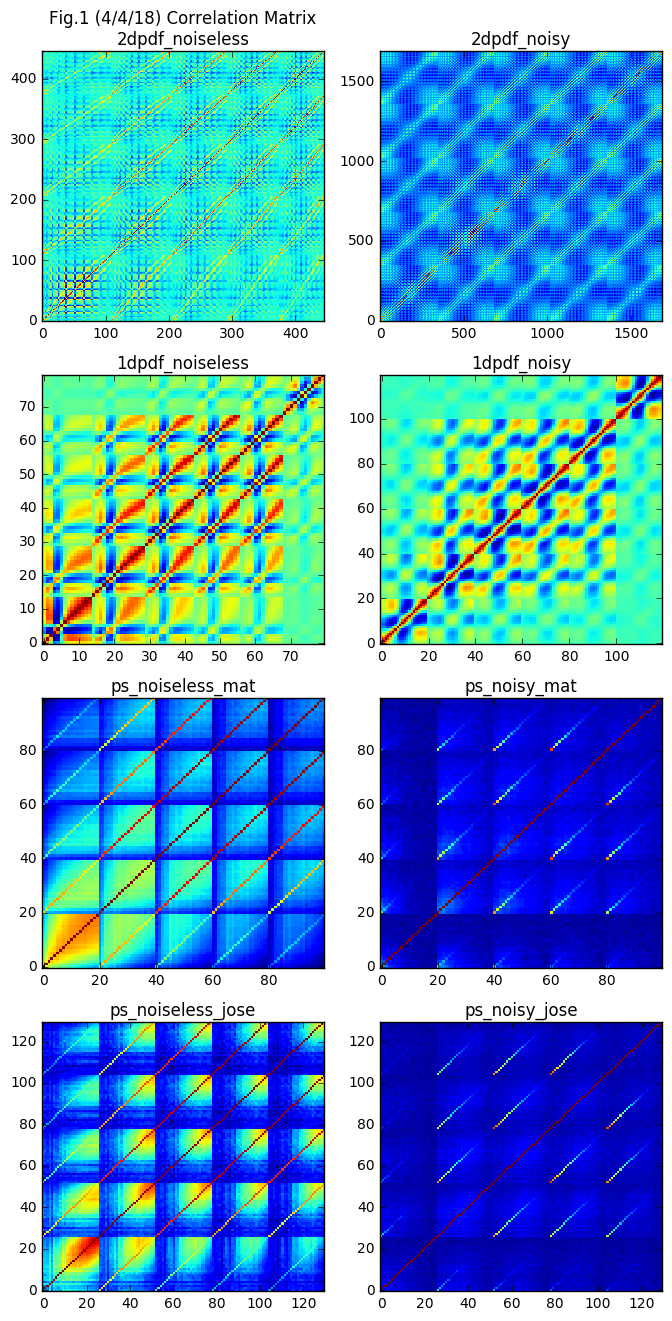

In [11]:
set_names = ['2dpdf_noiseless', '2dpdf_noisy',
             '1dpdf_noiseless', '1dpdf_noisy',
             'ps_noiseless_mat', 'ps_noisy_mat',
             'ps_noiseless_jose', 'ps_noisy_jose']
cov_arr = [cov2dI,cov2dN,
           cov1dI,cov1dN,
           covpsI_Mat,covpsN_Mat,
           covpsI_Jose,covpsN_Jose]

f, axes = subplots(4,2,figsize=(8,16))
for i in range(4):
    axes[i][0].imshow(WLanalysis.corr_mat(cov_arr[i*2]), origin='lower',aspect='auto',interpolation='nearest')
    axes[i][1].imshow(WLanalysis.corr_mat(cov_arr[i*2+1]), origin='lower',aspect='auto',interpolation='nearest')
    axes[i][0].set_title(set_names[i*2])
    axes[i][1].set_title(set_names[i*2+1])
axes[0][0].set_title('Fig.1 (4/4/18) Correlation Matrix\n'+set_names[0])
show()


In [12]:
######### now we prepare for fisher
######### we also add in for power spectrum, noisy covariance, but noiseless derivatives
alpha = lambda Nsim, Np: (Nsim - Np - 2.0) / (Nsim - 1.0)

Nsim_Np_arr = ((10000, 907), (10000, 1655), 
                (10000, 237), (10000, 300),
                (9000, 100), (9000, 100), (9000, 100), 
                (1000, 110), (9999, 110), (9999, 100)) 


alpha_arr = [alpha(iN[0], iN[1]) for iN in Nsim_Np_arr]
#print alpha_arr
cov_arr2 = [cov2dI,cov2dN,
           cov1dI,cov1dN,
           covpsI_Mat,covpsN_Mat,covpsN_Mat,
           covpsI_Jose,covpsN_Jose,covpsN_Jose]

covI_arr2 = [alpha_arr[i] * mat(cov_arr2[i]*(12.25/2e4)).I for i in range(len(alpha_arr))]

stats_arr2 = [pdf2dI_flat[1:], pdf2dN_flat[1:],
             pdf1dI_flat[1:], pdf1dN_flat[1:],
             psI_Mat_flat[1:], psN_Mat_flat[1:],psI_Mat_flat[1:],
             psI_Jose_flat, psN_Jose_flat,psI_Jose_flat]

set_names2 = ['2dpdf_noiseless', '2dpdf_noisy',
             '1dpdf_noiseless', '1dpdf_noisy',
             'ps_noiseless_mat', 'ps_noisy_mat (noisy der)',  
              'ps_noisy_mat (noiseless der)',
             'ps_noiseless_jose', 'ps_noisy_jose (noisy der)', 
              'ps_noisy_jose (noiseless der)',]

In [13]:
#for ir in (0.01, 0.05, 0.1):

ir = 0.05

params_der = array( [[[0.1*(1.0-ir/2), 0.3, 2.1],[0.1*(1.0+ir/2), 0.3, 2.1]] ,
                        [[0.1, 0.3*(1.0-ir/2), 2.1],[0.1, 0.3*(1.0+ir/2), 2.1]] ,
                        [[0.1, 0.3, 2.1*(1.0-ir/2)],[0.1, 0.3, 2.1*(1.0+ir/2)]]] )

der_arr = []
interp_arr = []
for istats in stats_arr2:
    iinterp = WLanalysis.buildInterpolator(istats, params[1:,])
    ider = array([(iinterp(params_der[i][1]) - iinterp(params_der[i][0]))/(fidu_params[i]*ir) for i in range(3)])
    der_arr.append(ider)
    interp_arr.append(iinterp)

Fisher_arr = [Fisher(covI_arr2[i], der_arr[i]) for i in range(len(covI_arr2))]

print 'Fisher error (noiseless) on [Mnu, omega_m, A_s], step size (%s)'%(ir)
i=0
for iF in Fisher_arr:
    print iF[1], set_names2[i]
    i+=1

Fisher error (noiseless) on [Mnu, omega_m, A_s], step size (0.05)
[ 0.00165846  0.00030776  0.0022298 ] 2dpdf_noiseless
[ 0.00091629  0.0003816   0.00131338] 2dpdf_noisy
[ 0.00091125  0.00024105  0.00274831] 1dpdf_noiseless
[ 0.00334462  0.00047178  0.00420391] 1dpdf_noisy
[ 0.00263589  0.0003352   0.00417779] ps_noiseless_mat
[ 0.00881305  0.00113896  0.00878659] ps_noisy_mat (noisy der)
[ 0.01614628  0.00204824  0.01787188] ps_noisy_mat (noiseless der)
[ 0.00204041  0.0002258   0.00326627] ps_noiseless_jose
[ 0.00753015  0.0010142   0.00837191] ps_noisy_jose (noisy der)
[ 0.01303132  0.0017182   0.01479568] ps_noisy_jose (noiseless der)


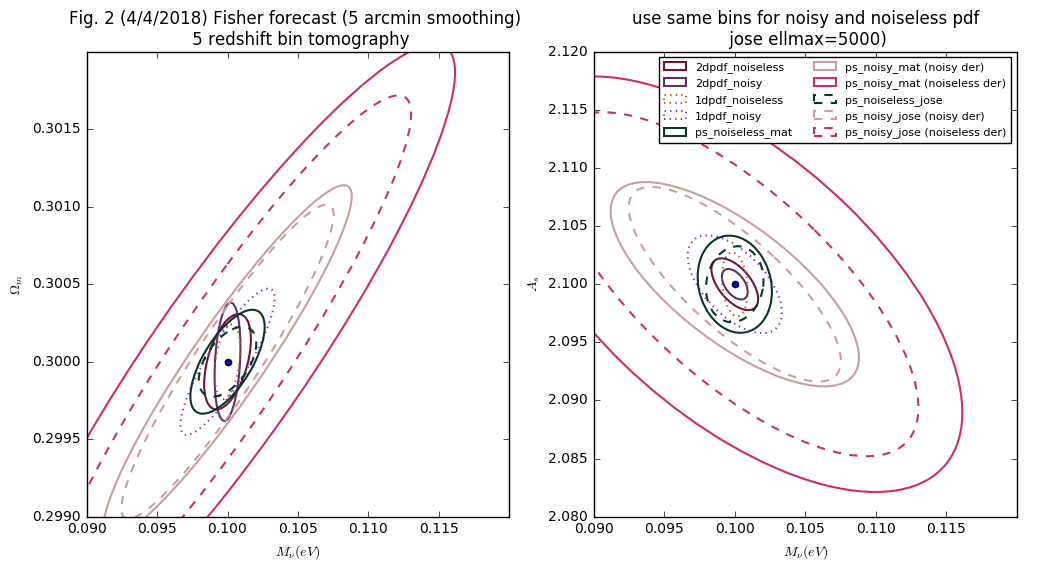

In [14]:
######## plot out all the fisher matrices, probably super busy..
lss = ['solid', 'solid', 
       'dotted','dotted', 
       'solid', 'solid', 'solid',
       'dashed','dashed','dashed']

f, (ax1,ax2) = subplots(1,2,figsize=(12,6))
ax1.scatter(0.1, 0.3)
ax2.scatter(0.1, 2.1)

jjj=0
seed(909)
colors = rand(10,3)
for iFF in Fisher_arr:
    #print jjj
    iF = iFF[0]
    icolor = colors[jjj]
    if jjj>6:
        icolor = colors[jjj-3]
    ilabel=set_names2[jjj]
    plotEllipse([0.1, 0.3], mat(iF).I[[0,1],:][:,[0,1]] ,icolor,lss[jjj],ilabel,ax1)
    plotEllipse([0.1, 2.1], mat(iF).I[[0,2],:][:,[0,2]] ,icolor,lss[jjj],ilabel,ax2)
    jjj+=1
ax1.set_xlim(0.09, 0.12)#(0.07,0.14)
ax1.set_ylim(0.299, .302)#(0.296,0.306)
ax2.set_xlim(0.09, 0.12)#(0.07,0.14)
ax2.set_ylim(2.08, 2.12)#(2.05,2.15)
ax1.set_xlabel(r'$M_\nu(eV)$')
ax1.set_ylabel(r'$\Omega_m$')
ax2.set_xlabel(r'$M_\nu(eV)$')
ax2.set_ylabel(r'$A_s$')
ax2.legend(fontsize=8,frameon=1,ncol=2)
ax1.set_title('Fig. 2 (4/4/2018) Fisher forecast (5 arcmin smoothing) \n 5 redshift bin tomography')
ax2.set_title('use same bins for noisy and noiseless pdf\n jose ellmax=5000)')
show()

In [15]:
########## here are the bin indices for each redshifts
#print idx_2dI
#print idx_1dI
edges2dI = arange(0, 5*(60/Nc)**2 +1, (60/Nc)**2)
edges1dI = arange(0, 6*(60/Nc)+1, (60/Nc))
bins2dI = [sum ( (idx_2dI>edges2dI[i]) & (idx_2dI < edges2dI[i+1])) for i in range(5)]
bins1dI = [sum ( (idx_1dI>edges1dI[i]) & (idx_1dI < edges1dI[i+1])) for i in range(5)]
edgeright2dI = [0,]+[sum (idx_2dI < edges2dI[i+1]) for i in range(5)]
edgeright1dI = [0,]+[sum (idx_1dI < edges1dI[i+1]) for i in range(5)]
print bins2dI, sum(bins2dI), edgeright2dI
print bins1dI, sum(bins1dI), edgeright1dI

[109, 96, 87, 81, 73] 446 [0, 109, 205, 292, 373, 446]
[14, 15, 14, 13, 12] 68 [0, 14, 29, 43, 56, 68]


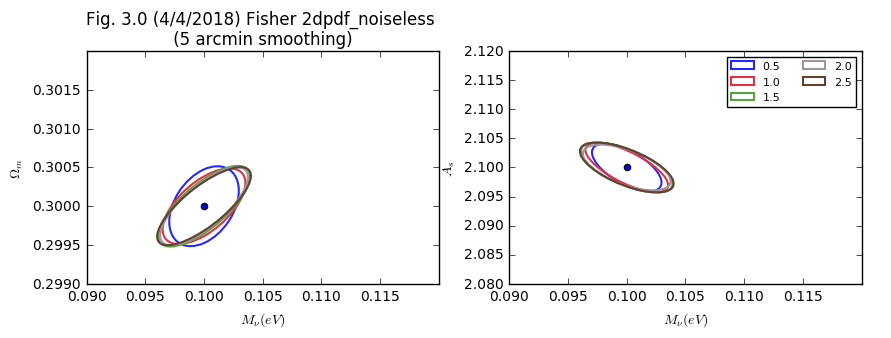

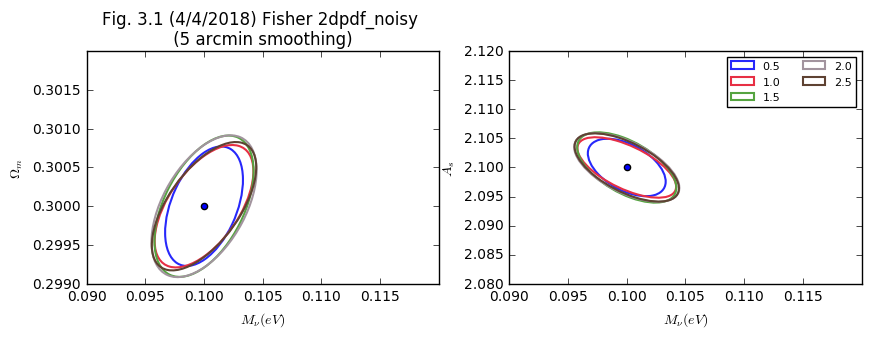

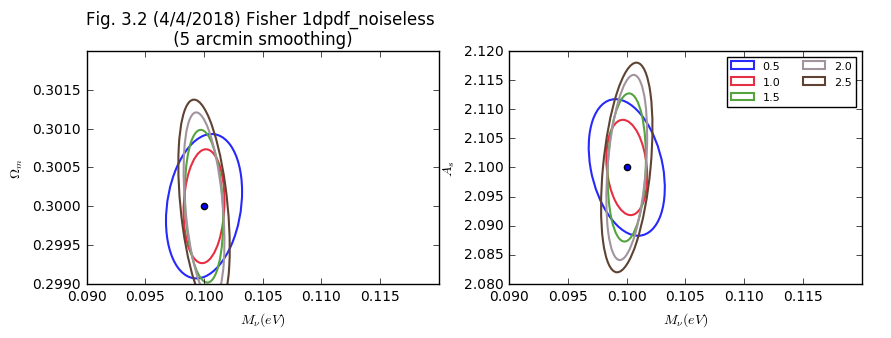

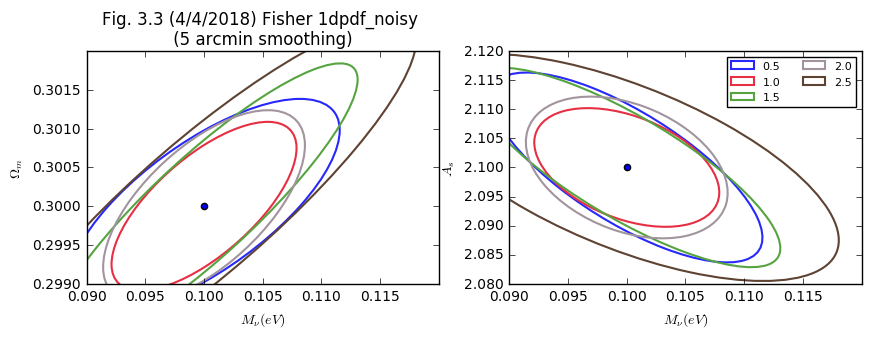

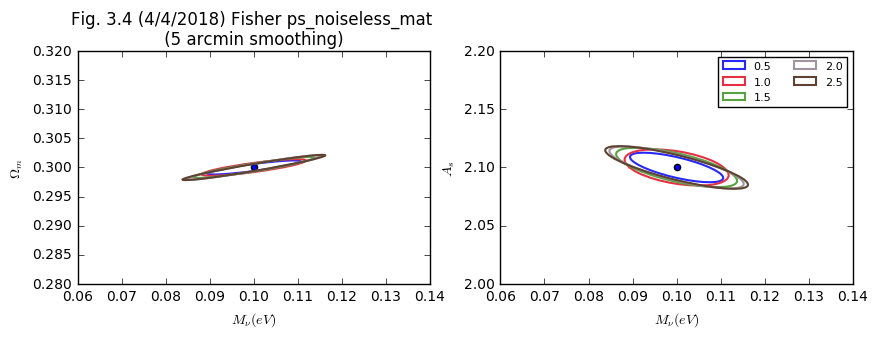

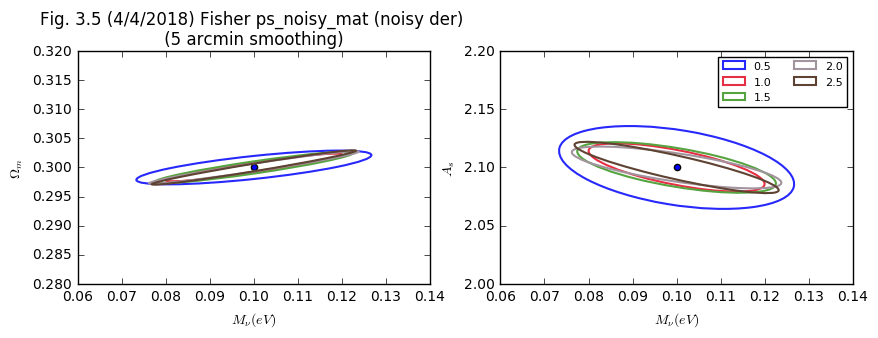

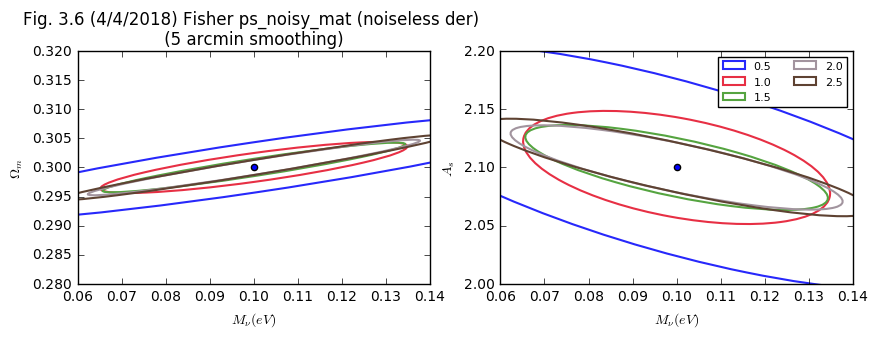

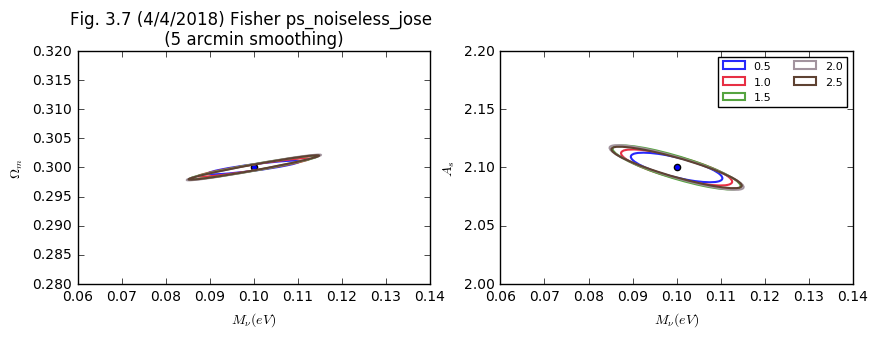

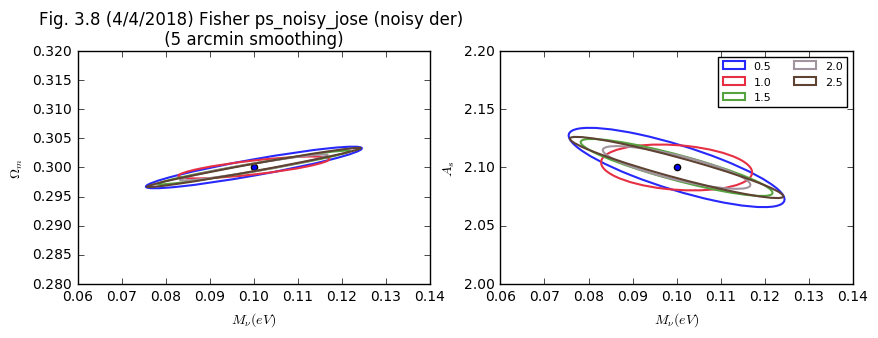

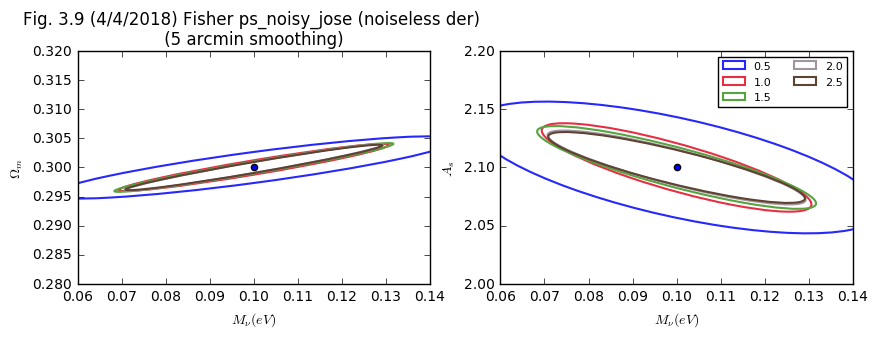

In [17]:
######## now lets test for each redshift bins

cov_arr2 = [cov2dI,cov2dN,
           cov1dI,cov1dN,
           covpsI_Mat,covpsN_Mat,covpsN_Mat,
           covpsI_Jose,covpsN_Jose,covpsN_Jose]
stats_arr2 = [pdf2dI_flat[1:], pdf2dN_flat[1:],
             pdf1dI_flat[1:], pdf1dN_flat[1:],
             psI_Mat_flat[1:], psN_Mat_flat[1:],psI_Mat_flat[1:],
             psI_Jose_flat, psN_Jose_flat,psI_Jose_flat]

i = -1
for icov5z in cov_arr2:
    i+=1    
    if i<2:
        iedges = edgeright2dI
    elif i<4:
        iedges = edgeright1dI
    else:
        isize = icov5z.shape[0]
        iedges = arange(0, isize+1, isize/5)

    f, (ax1,ax2) = subplots(1,2,figsize=(10,3))
    ax1.scatter(0.1, 0.3)
    ax2.scatter(0.1, 2.1)

    jjj=0
    seed(90)
    colors = rand(10,3)   
    for j in range(5):     
        iL,iR = iedges[j:j+2]
        icov1z = icov5z[iL:iR, iL:iR]
        #print iL, iR, icov1z.shape
        icov1zI = mat(icov1z*(12.25/2e4)).I
        iider = der_arr[i][:,iL:iR]
        iF1z = Fisher(icov1zI, iider)
        
        iF = iF1z[0]
        icolor = colors[jjj]
        plotEllipse([0.1, 0.3], mat(iF).I[[0,1],:][:,[0,1]] ,icolor,'solid',z_source[j],ax1)
        plotEllipse([0.1, 2.1], mat(iF).I[[0,2],:][:,[0,2]] ,icolor,'solid',z_source[j],ax2)
        jjj+=1
        
    ax1.set_xlim(0.09, 0.12)
    ax1.set_ylim(0.299, .302)
    ax2.set_xlim(0.09, 0.12)
    ax2.set_ylim(2.08, 2.12)
    if i>3:
        ax1.set_xlim(0.06, 0.14)
        ax1.set_ylim(0.28, .32)
        ax2.set_xlim(0.06, 0.14)
        ax2.set_ylim(2.0, 2.2)
    ax1.set_xlabel(r'$M_\nu(eV)$')
    ax1.set_ylabel(r'$\Omega_m$')
    ax2.set_xlabel(r'$M_\nu(eV)$')
    ax2.set_ylabel(r'$A_s$')
    ax2.legend(fontsize=8,frameon=1,ncol=2)
    ax1.set_title('Fig. 3.%i (4/4/2018) Fisher %s \n (5 arcmin smoothing) '%(i,set_names2[i]))
    #ax2.set_title('use same bins for noisy/noiseless pdf\n jose ellmax=5000')
   show()    

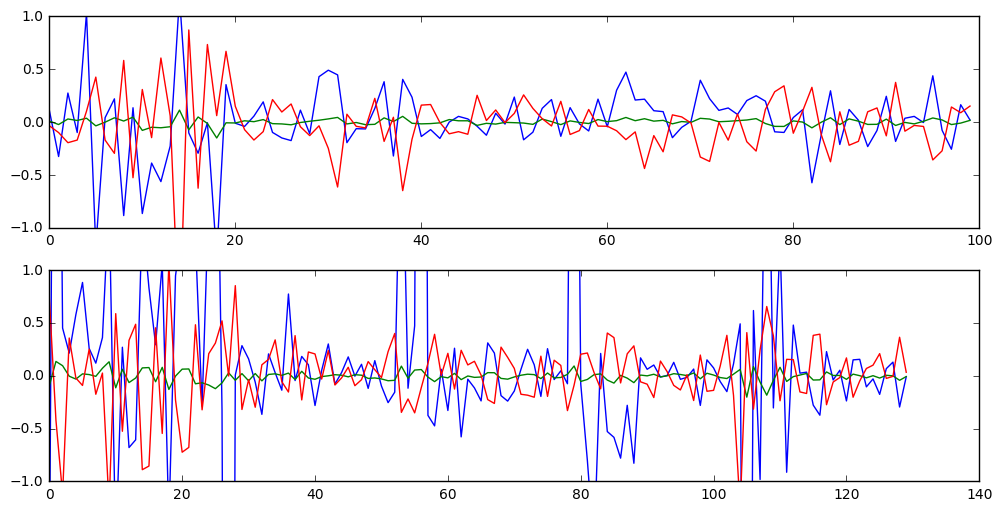

In [31]:
# set_names2 = ['2dpdf_noiseless', '2dpdf_noisy',
#              '1dpdf_noiseless', '1dpdf_noisy',
#              'ps_noiseless_mat', 'ps_noisy_mat (noisy der)',  
#               'ps_noisy_mat (noiseless der)',
#              'ps_noiseless_jose', 'ps_noisy_jose (noisy der)', 
#               'ps_noisy_jose (noiseless der)',]

ell_edges = linspace(100,3000,21)
ell_mat = WLanalysis.edge2center(ell_edges)
ell_jose = ellJ[idxJ]

ell_mat5 = list(ell_mat)*5
ell_jose5 = list(ell_jose)*5

#print len(ell_mat5), len(ell_jose5)

f, (ax0, ax1) = subplots(2,1, figsize=(12,6))
for j in range(3):
    ax0.plot(der_arr[5][j]/der_arr[4][j]-1)
    ax1.plot(der_arr[8][j]/der_arr[7][j]-1)
ax0.set_ylim(-1,1)
ax1.set_ylim(-1,1)
show()

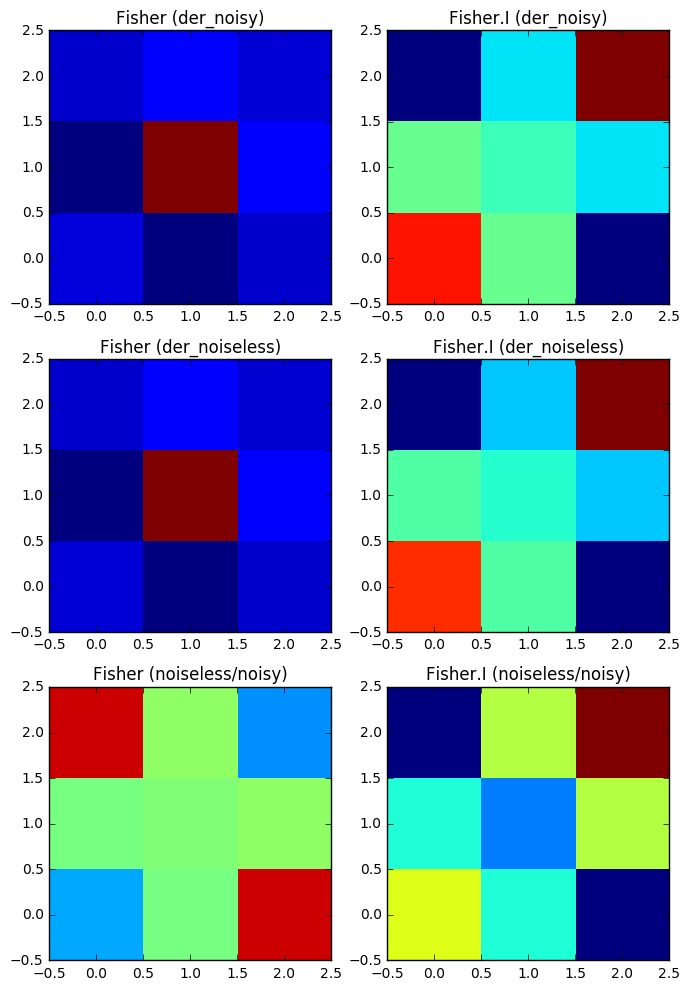

In [50]:
f, ((ax1,ax2),(ax1b,ax2b), (ax1c,ax2c)) = subplots(3,2, figsize=(8,12))
ax1.imshow(Fisher_arr[-2][0],origin='lower',aspect='auto',interpolation='nearest')
ax1.set_title('Fisher (der_noisy)')
ax1b.imshow(Fisher_arr[-1][0],origin='lower',aspect='auto',interpolation='nearest')
ax1b.set_title('Fisher (der_noiseless)')
ax2.imshow(mat(Fisher_arr[-2][0]).I,origin='lower',aspect='auto',interpolation='nearest')
ax2.set_title('Fisher.I (der_noisy)')
ax2b.imshow(mat(Fisher_arr[-1][0]).I,origin='lower',aspect='auto',interpolation='nearest')
ax2b.set_title('Fisher.I (der_noiseless)')

ax1c.imshow(Fisher_arr[-1][0]/Fisher_arr[-2][0]-1,origin='lower',aspect='auto',interpolation='nearest',vmin=-0.5,vmax=0.5)
ax1c.set_title('Fisher (noiseless/noisy)')
ax2c.imshow(mat(Fisher_arr[-1][0]).I/mat(Fisher_arr[-2][0]).I-1,origin='lower',aspect='auto',interpolation='nearest')#,vmin=-0.5,vmax=0.5)
ax2c.set_title('Fisher.I (noiseless/noisy)')
show()


In [67]:
#Fisher_arr = [Fisher(covI_arr2[i], der_arr[i]) for i in range(len(covI_arr2))]
icovI = covI_arr2[-1] ## noisy covariance
idr = der_arr[-1] ## noiseless derivatives

for ix in linspace(0,2,6):
    seed(0)
    inoise = 1 + (rand(3,idr.shape[1]) - 0.5)*ix
    iF = Fisher(icovI, idr*inoise)
    #iFnoise = Fisher(icovI, idr*(inoise-1))
    print 'Noise Level: %.1f, 1 sigma CL: %s'%(ix,  iF[1])#, iFnoise[1]

Noise Level: 0.0, 1 sigma CL: [ 0.01303132  0.0017182   0.01479568]
Noise Level: 0.4, 1 sigma CL: [ 0.00639401  0.00067693  0.00723874]
Noise Level: 0.8, 1 sigma CL: [ 0.00392696  0.00035481  0.00482258]
Noise Level: 1.2, 1 sigma CL: [ 0.00284711  0.00024234  0.00362635]
Noise Level: 1.6, 1 sigma CL: [ 0.00223831  0.00018596  0.00290024]
Noise Level: 2.0, 1 sigma CL: [ 0.00184998  0.00015193  0.00241797]


In [68]:
########## check if different cosmology, has power spectrum
ps0_nl = load('test/ALL_igalXigal_1.0_1.0_model-0.npy')
ps1_nl = load('test/ALL_igalXigal_1.0_1.0_model-1.npy')
ps0_ny = load('test/ALL_galXgal_1.0_1.0_model-0.npy')
ps1_ny = load('test/ALL_galXgal_1.0_1.0_model-1.npy')

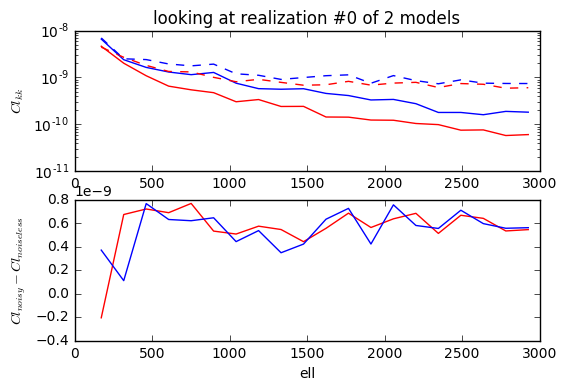

In [83]:
f, (ax1,ax2) = subplots(2,1)
ax1.plot(ell_mat,ps0_nl[0], 'r-')
ax1.plot(ell_mat,ps1_nl[0], 'b-')
ax1.set_yscale('log')

ax1.plot(ell_mat, ps0_ny[0], 'r--')
ax1.plot(ell_mat, ps1_ny[0], 'b--')

ax2.plot(ell_mat, ps0_ny[0]-ps0_nl[0],'r-')
ax2.plot(ell_mat, ps1_ny[0]-ps1_nl[0],'b-')

ax2.set_xlabel('ell')
ax1.set_ylabel('$Cl_{kk}$')
ax2.set_ylabel(r'$Cl_{noisy} - Cl_{noiseless}$')
ax1.set_title('looking at realization #0 of 2 models')
show()

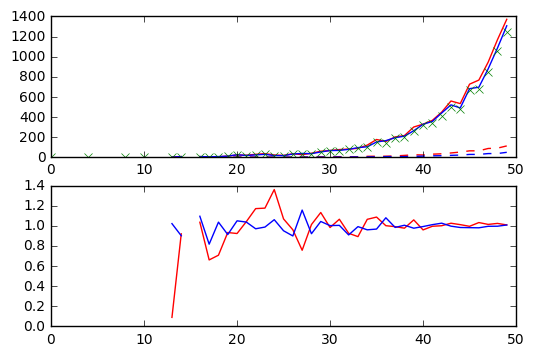

In [97]:
seed(1)
noisemap=rand(100,100)*100
realmap=rand(100,100)*30
realmap2=rand(100,100)*20
PS_noise = WLanalysis.PowerSpectrum(noisemap)[1]
PS_real = WLanalysis.PowerSpectrum(realmap)[1]
PS_real2 = WLanalysis.PowerSpectrum(realmap2)[1]
PS_tot = WLanalysis.PowerSpectrum(noisemap+realmap)[1]
PS_tot2 = WLanalysis.PowerSpectrum(noisemap+realmap2)[1]

f, (ax1,ax2) = subplots(2,1)
ax1.plot(PS_real,'r--')
ax1.plot(PS_real2,'b--')
ax1.plot(PS_tot,'r-')
ax1.plot(PS_tot2,'b-')
ax1.plot(PS_noise,'gx')
ax2.plot( (PS_tot-PS_real) / PS_noise,'r-')
ax2.plot( (PS_tot2-PS_real2) / PS_noise,'b-')

show()

In [90]:
(PS_tot-PS_noise)/PS_real

array([ 1.30708323,         nan,         nan,         nan, -0.03726095,
               nan,         nan,         nan,  1.49063356,         nan,
        1.91077759,         nan,         nan,  1.43719654,  1.08439442,
               nan,  1.25820617,  0.50290705,  1.21595136,  0.41074249,
        0.98717933,  0.26063576,  1.83007251,  1.85134841,  1.02727362,
        1.17355048,  0.31494009,  1.68932723,  1.31079392,  0.64572596,
        0.76577076,  1.0912031 ,  0.97925317,  1.10853346,  0.54465225,
        0.98626248,  1.07164119,  1.02527825,  1.14930339,  1.1537258 ,
        0.98886103,  1.05845007,  1.01628343,  1.03011809,  0.94787457,
        0.90955419,  1.03256276,  0.94401517,  0.98481666,  0.92310731])